In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchinfo import summary
from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pandas import read_csv

In [2]:
import random
import os

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
# torch.use_deterministic_algorithms(True)

'cuda'

# Loading Dataset

In [3]:
train = pd.read_csv('/kaggle/input/har-using-deep-nn/train.csv')
train.sample()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
4525,0.283203,-0.047024,-0.168986,0.384949,0.176898,-0.310332,0.381757,0.122611,-0.332984,0.465563,...,-0.034924,0.558036,0.258975,-0.854858,-0.78433,0.22296,-0.066506,22,3,WALKING_DOWNSTAIRS


In [4]:
train.shape

(7352, 564)

In [5]:
test = pd.read_csv('/kaggle/input/har-using-deep-nn/test.csv')
test.sample()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
718,0.3659,-0.031332,-0.024079,0.183421,-0.344568,-0.403268,0.09989,-0.3422,-0.412337,0.4803,...,-0.37837,-0.840289,-0.864326,0.848585,-0.960939,0.116422,-0.003858,9,3,WALKING_DOWNSTAIRS


In [6]:
test.shape

(2947, 564)

In [7]:
print('Duplicates in train = {}'.format(sum(train.duplicated())))
print('Duplicates in test = {}'.format(sum(test.duplicated())))
print('Invalid values in train = {}'.format(train.isnull().values.sum()))
print('Invalid values in test = {}'.format(test.isnull().values.sum()))

Duplicates in train = 0
Duplicates in test = 0
Invalid values in train = 0
Invalid values in test = 0


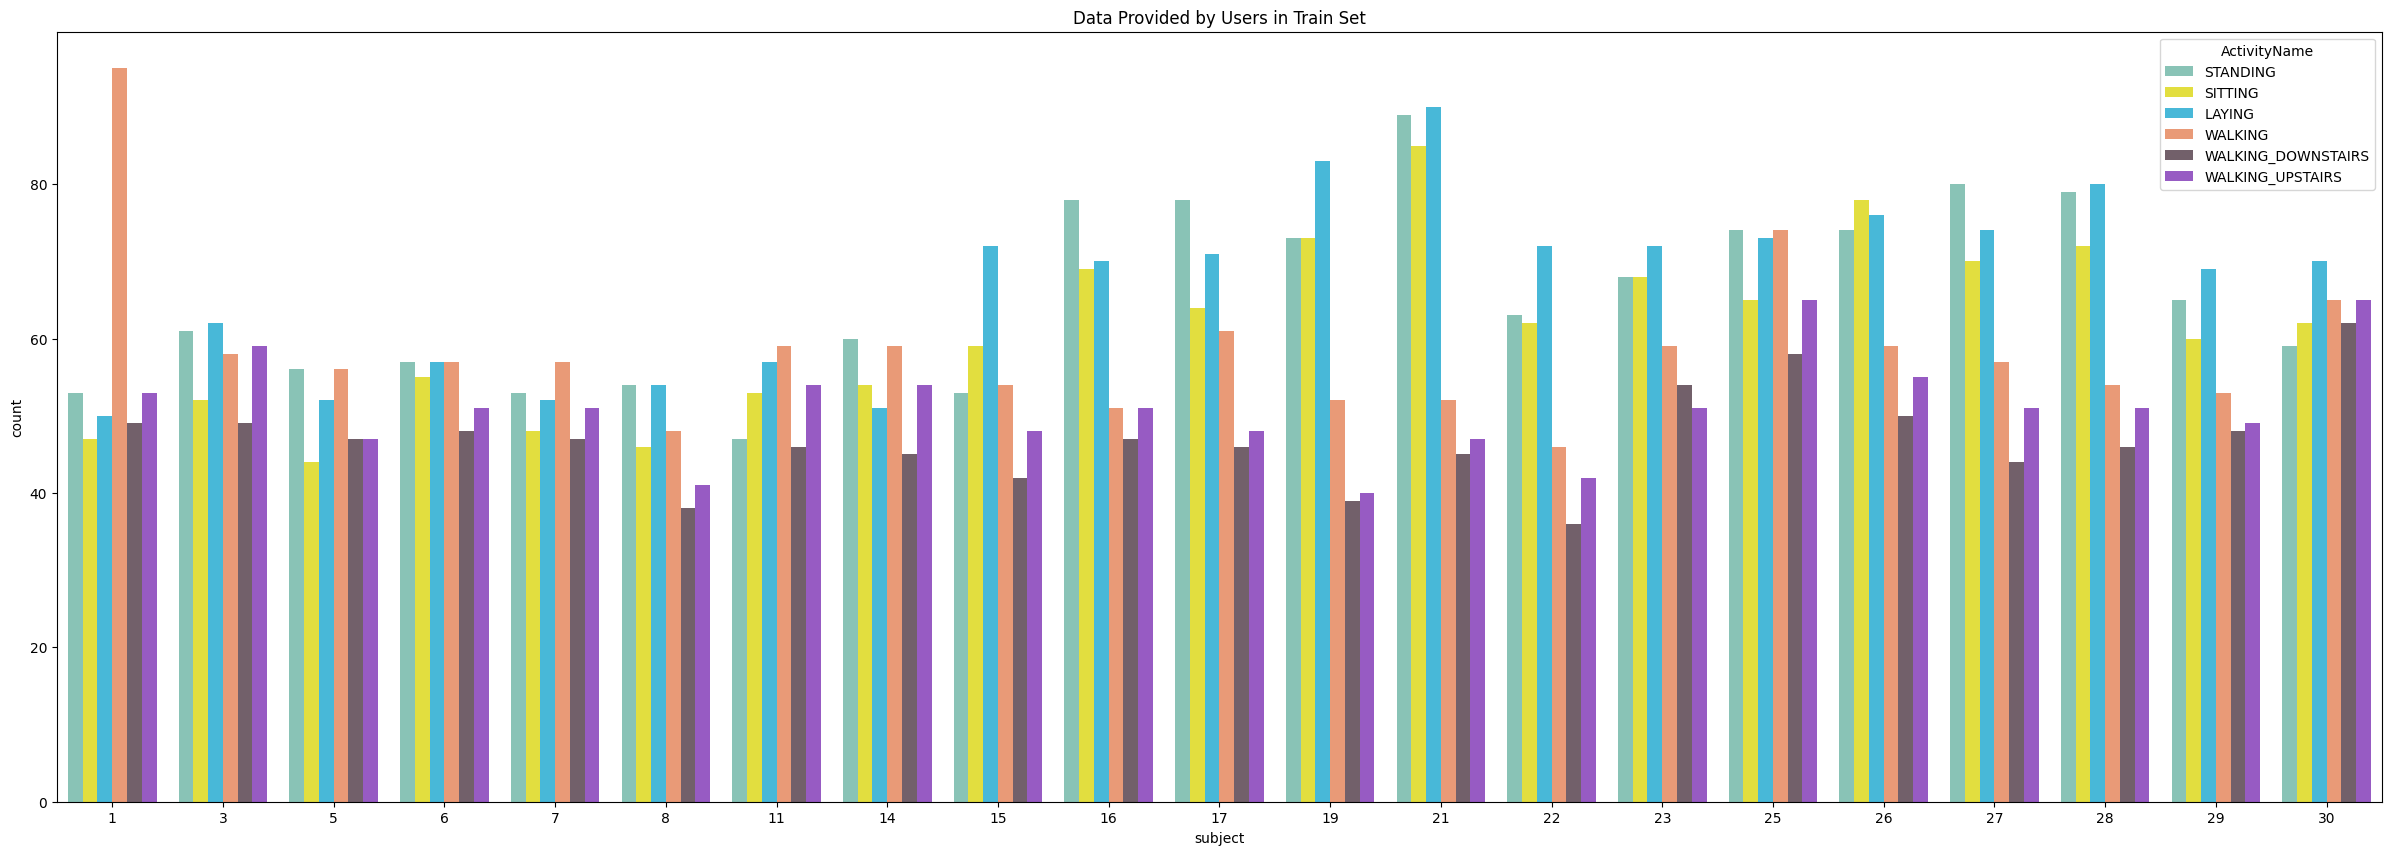

In [8]:
plt.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = train)
plt.title('Data Provided by Users in Train Set')
plt.show()

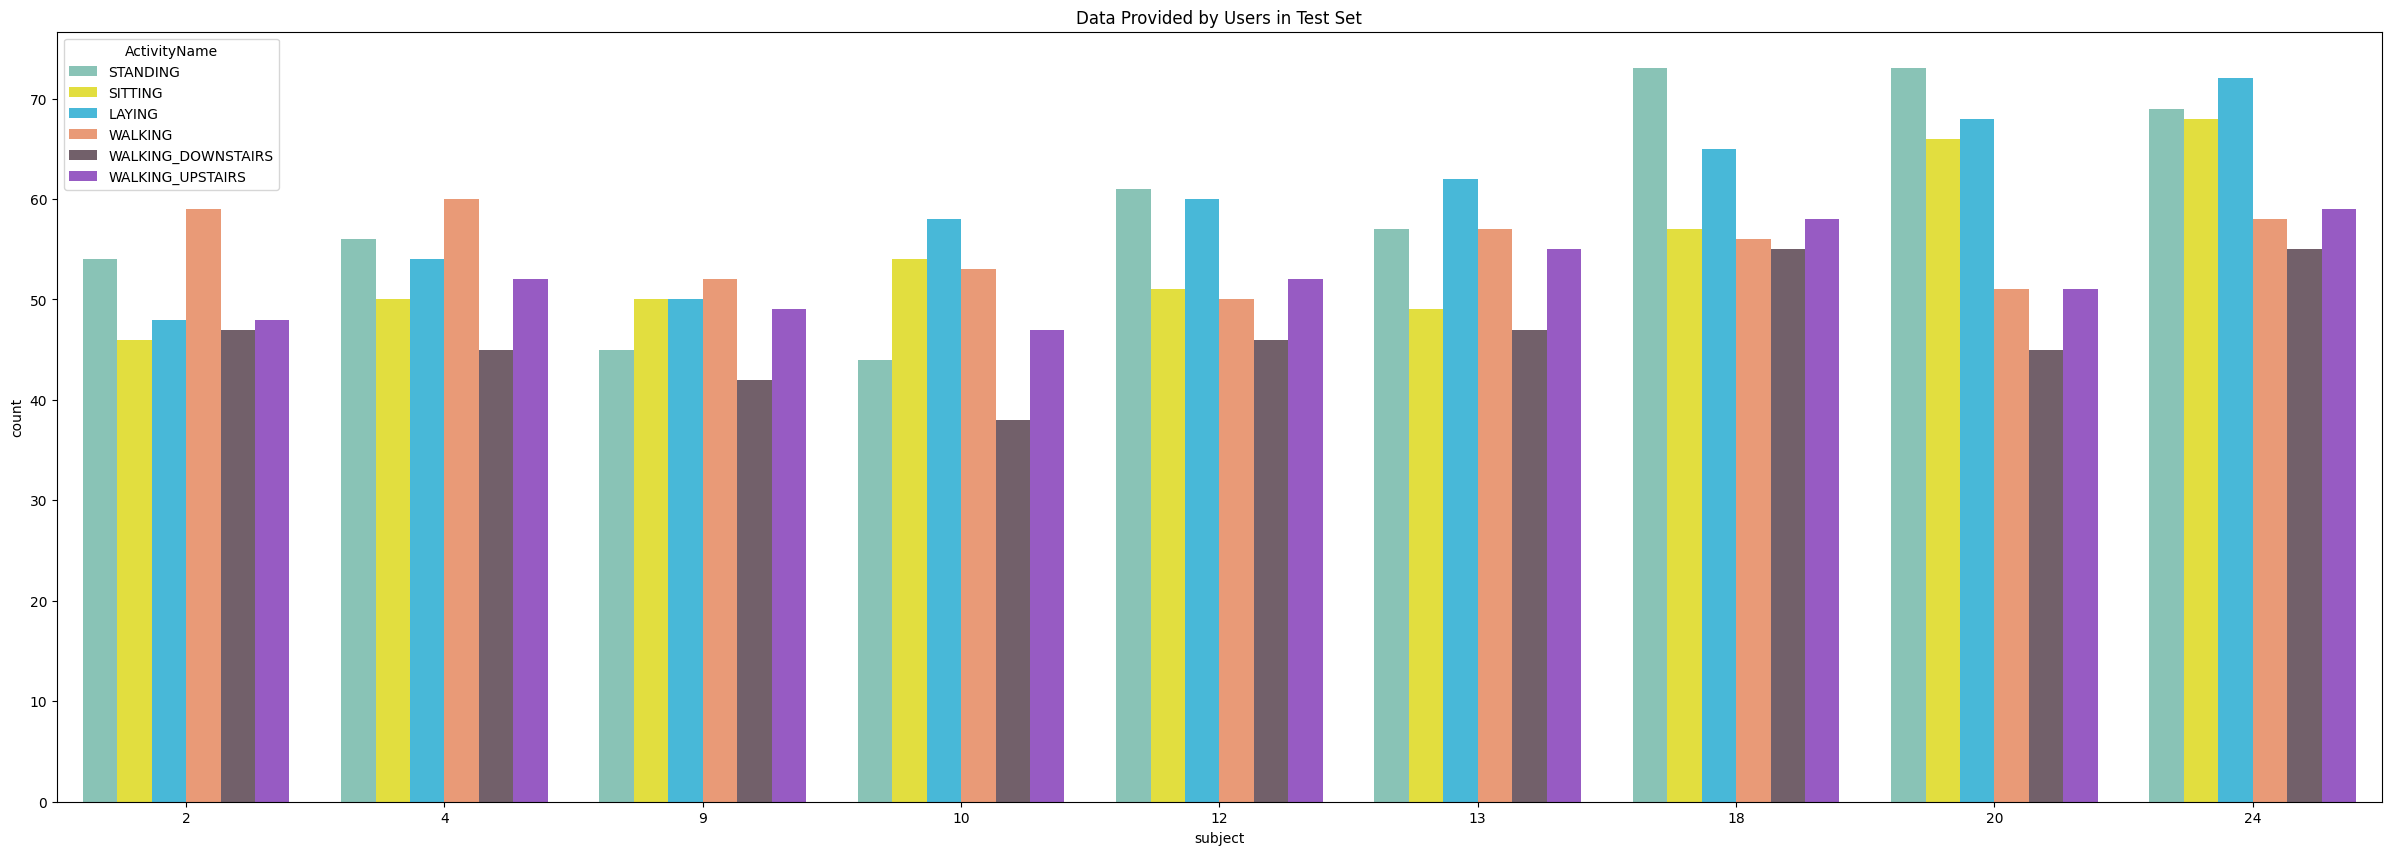

In [9]:
plt.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = test)
plt.title('Data Provided by Users in Test Set')
plt.show()

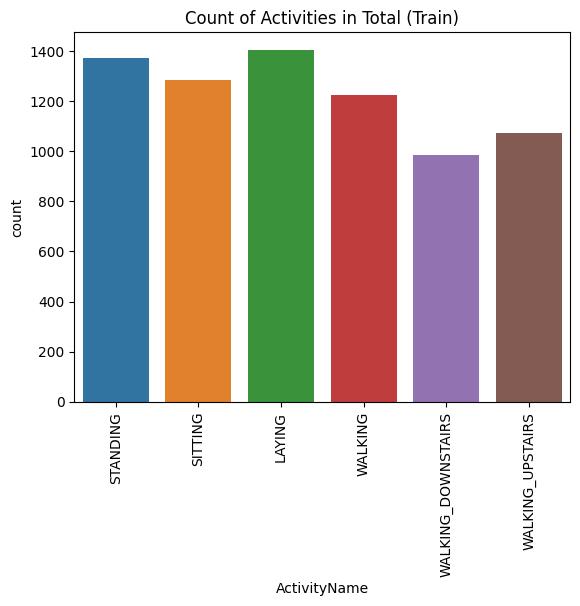

In [10]:
plt.title('Count of Activities in Total (Train)')
sns.countplot(x="ActivityName",data=train)
plt.xticks(rotation=90)
plt.show()

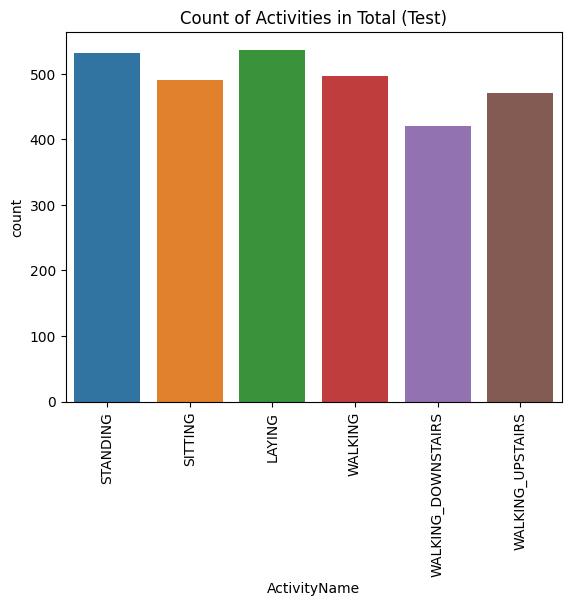

In [11]:
plt.title('Count of Activities in Total (Test)')
sns.countplot(x="ActivityName",data=test)
plt.xticks(rotation=90)
plt.show()

In [12]:
def file_load(filepath):
    df = read_csv(filepath, header=None, sep='\s+')
    return df.values

In [13]:
def train_test_append(filenames, append_before=''):
    datalist = list()
    for name in filenames:
        data = file_load(append_before + name)
        datalist.append(data)
    datalist = np.dstack(datalist)
    return datalist

In [14]:
def inertial_signals_load(group, append_before=''):
    filepath = append_before + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = train_test_append(filenames, filepath)
    y = file_load(append_before + group + '/y_'+group+'.txt')
    return X, y

In [15]:
def load_dataset(append_before=''):
    trainX, trainy = inertial_signals_load('train', append_before + '/kaggle/input/ucihar-dataset/UCI-HAR Dataset/')
    testX, testy = inertial_signals_load('test', append_before + '/kaggle/input/ucihar-dataset/UCI-HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = pd.get_dummies(trainy[:,0], dtype=int).values
    testy = pd.get_dummies(testy[:,0], dtype=int).values
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [16]:
trainX, trainy, testX, testy = load_dataset()
verbose, epochs, batch_size = 0, 100, 200
n_timesteps = trainX.shape[1]
n_features = trainX.shape[2]
n_outputs = trainy.shape[1]
# n_steps = 4
# n_length = 32
# trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
# testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features)) 
print(trainX.shape,testX.shape)

(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(7352, 128, 9) (2947, 128, 9)


## Setting Up the train and test loaders

In [17]:
class HARDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
train_dataset = HARDataset(trainX, trainy)
test_dataset = HARDataset(testX, testy)

BATCH = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

# Modelling

## Loss Function

In [ ]:
def kl_divergence_loss(preds, targets):
    # Ensure that the predictions and targets are probabilities
    preds = F.softmax(preds, dim=-1)
    targets = F.softmax(targets, dim=-1)
    loss = F.kl_div(preds.log(), targets, reduction='batchmean')
    return loss

def mse_loss(preds, targets):
    # Ensure that the predictions and targets are one-hot encoded
    preds = F.softmax(preds, dim=-1)
    return F.mse_loss(preds, targets)

# Focal Loss
def focal_loss(preds, targets, alpha=0.25, gamma=2.0):
    """
    Focal Loss for multi-class classification.
    
    Arguments:
    preds -- the raw logits from the model (shape: [batch_size, num_classes])
    targets -- the true labels (shape: [batch_size])
    alpha -- balancing factor for class imbalances (default is 0.25)
    gamma -- focusing parameter (default is 2.0)
    
    Returns:
    loss -- the computed focal loss
    """
    # Apply softmax to get probabilities
    preds = F.softmax(preds, dim=-1)
    
    # Convert targets to one-hot encoding
    targets_one_hot = targets
    
    # Cross-entropy loss
    ce_loss = F.cross_entropy(preds, targets, reduction='none')
    
    # Get the predicted probability for the correct class
    pt = torch.exp(-ce_loss)
    
    # Compute focal loss
    focal_loss = alpha * (1 - pt) ** gamma * ce_loss
    
    return focal_loss.mean()

# criterion = nn.CrossEntropyLoss() # -> 96.89% 93.55%
criterion = kl_divergence_loss # -> 99.09% 94.81%
# criterion = mse_loss # -> 96.27% 92.94%
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # -> 97.43% 94.06%
# criterion = focal_loss # -> 97.27% 93.32%

## Optimizer and Learning Rate

In [ ]:
def warmup_lr(epoch, step_size, warmup_epochs=5, gamma=0.1):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    
    else:
        epoch_since_warmup = epoch - warmup_epochs
        return gamma ** (epoch_since_warmup // step_size)

WARMUP_EPOCHS = 14
GAMMA = 0.1
STEP_SIZE = 20

optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: warmup_lr(x, warmup_epochs=WARMUP_EPOCHS, gamma=GAMMA, step_size=STEP_SIZE))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min = 1e-6)

## Plotting

In [ ]:
# Plot history
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History')

    plt.show()

## Models

### RNN + Attention

In [19]:
class AdaptiveRNN(nn.Module):
    def __init__(self, n_timesteps, n_features, n_outputs):
        super(AdaptiveRNN, self).__init__()

        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )
        self.batch_norm = nn.BatchNorm1d(128 * 2)

        # Attention mechanism
        self.attention_dense = nn.Linear(128 * 2, 1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, timesteps, 128*2)
        
        batch_size, n_timesteps, n_features = lstm_out.size()
        lstm_out = lstm_out.reshape(batch_size * n_timesteps, n_features)
        lstm_out = self.batch_norm(lstm_out)
        lstm_out = lstm_out.reshape(batch_size, n_timesteps, n_features)
        
        # Attention mechanism
        attention_scores = torch.sigmoid(self.attention_dense(lstm_out))  # (batch_size, timesteps, 1)
        attention_scores = lstm_out * attention_scores  # Weighted timesteps

        # Global average pooling
        pooled = attention_scores.mean(dim=1)
        
        # Fully connected layers
        x = F.relu(self.fc1(pooled))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.softmax(x, dim=1)

In [20]:
# Define the model parameters
n_timesteps = 32 * 4  # 128 timesteps
n_features = 9
n_outputs = 6

# Create the model
model = AdaptiveRNN(n_timesteps=n_timesteps, n_features=n_features, n_outputs=n_outputs).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
AdaptiveRNN                              --
├─LSTM: 1-1                              142,336
├─BatchNorm1d: 1-2                       512
├─Linear: 1-3                            257
├─Linear: 1-4                            32,896
├─Linear: 1-5                            8,256
├─Linear: 1-6                            390
├─Dropout: 1-7                           --
Total params: 184,647
Trainable params: 184,647
Non-trainable params: 0

In [ ]:
history = train_model(model, train_loader, test_loader, epochs=150, device=device, early_stopping=False)

In [ ]:
plot_history(history)

### TCN Model

In [23]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rate):
        super(TCNBlock, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding='same',
            dilation=dilation_rate
        )
        self.batch_norm = nn.BatchNorm1d(out_channels)

        # Residual connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.batch_norm(out)

        shortcut = self.shortcut(x) if self.shortcut is not None else x
        return F.relu(out + shortcut)

class TCNModel(nn.Module):
    def __init__(self, n_length, n_features, n_outputs):
        super(TCNModel, self).__init__()

        self.tcn_blocks = nn.Sequential(
            TCNBlock(n_features, 64, kernel_size=3, dilation_rate=1),
            TCNBlock(64, 64, kernel_size=3, dilation_rate=2),
            TCNBlock(64, 64, kernel_size=3, dilation_rate=4),
            TCNBlock(64, 64, kernel_size=3, dilation_rate=8)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, n_features, n_length)
        x = self.tcn_blocks(x)

        x = self.global_avg_pool(x).squeeze(-1)  # Global average pooling

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return F.softmax(x, dim=1)

# Define model parameters
n_length = 128  
n_features = 9
n_outputs = 6

In [ ]:
# Instantiate model
model = TCNModel(n_length, n_features, n_outputs).to(device)
summary(model)

In [ ]:
history = train_model(model, train_loader, test_loader, epochs=120, device=device, early_stopping=False)

In [ ]:
plot_history(history)

### TCN + CBAM Model

In [171]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Conv1d(in_channels, in_channels // reduction_ratio, kernel_size=1)
        self.fc2 = nn.Conv1d(in_channels // reduction_ratio, in_channels, kernel_size=1)

    def forward(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_out = F.relu(self.fc1(avg_pool))
        avg_out = self.fc2(avg_out)

        max_out = F.relu(self.fc1(max_pool))
        max_out = self.fc2(max_out)

        out = avg_out + max_out
        return torch.sigmoid(out) * x  # Channel attention applied

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_pool, max_pool], dim=1)  # Concatenate along channel dimension
        out = self.conv(x_cat)
        return self.sigmoid(out) * x  # Spatial attention applied

class CBAMBlock(nn.Module):
    def __init__(self, in_channels):
        super(CBAMBlock, self).__init__()
        self.channel_attention = ChannelAttention(in_channels)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

class TCNWithCBAM(nn.Module):
    def __init__(self, n_length, n_features, n_outputs):
        super(TCNWithCBAM, self).__init__()

        self.tcn_blocks = nn.Sequential(
            TCNBlock(n_features, 64, kernel_size=3, dilation_rate=1),
            TCNBlock(64, 128, kernel_size=3, dilation_rate=2),
            TCNBlock(128, 256, kernel_size=3, dilation_rate=4),
            TCNBlock(256, 512, kernel_size=3, dilation_rate=8)
        ) # (batch_size, out_channels, n_length)

        self.cbam_block = CBAMBlock(512)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.batch_norm = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, n_features, n_length)
        x = self.tcn_blocks(x)
        x = self.batch_norm(x)

        # Apply CBAM
        x = self.cbam_block(x)

        x = self.global_avg_pool(x).squeeze(-1)  # Global average pooling

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return F.softmax(x, dim=1)

# Define model parameters
n_length = 128  
n_features = 9
n_outputs = 6

In [172]:
model = TCNWithCBAM(n_length, n_features, n_outputs).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
TCNWithCBAM                              --
├─Sequential: 1-1                        --
│    └─TCNBlock: 2-1                     --
│    │    └─Conv1d: 3-1                  1,792
│    │    └─BatchNorm1d: 3-2             128
│    │    └─Conv1d: 3-3                  640
│    └─TCNBlock: 2-2                     --
│    │    └─Conv1d: 3-4                  24,704
│    │    └─BatchNorm1d: 3-5             256
│    │    └─Conv1d: 3-6                  8,320
│    └─TCNBlock: 2-3                     --
│    │    └─Conv1d: 3-7                  98,560
│    │    └─BatchNorm1d: 3-8             512
│    │    └─Conv1d: 3-9                  33,024
│    └─TCNBlock: 2-4                     --
│    │    └─Conv1d: 3-10                 393,728
│    │    └─BatchNorm1d: 3-11            1,024
│    │    └─Conv1d: 3-12                 131,584
├─CBAMBlock: 1-2                         --
│    └─ChannelAttention: 2-5             --
│    │    └─AdaptiveAvgPool1d: 3-13 

In [ ]:
history = train_model(model, train_loader, test_loader, epochs=150, device=device, early_stopping=True)

Epoch 1/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 58.78batch/s, loss=0.125]


Epoch 1/150 - Train Loss: 0.0582, Train Acc: 0.6298 - Val Loss: 0.1017, Val Acc: 0.2019


Epoch 2/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.44batch/s, loss=0.000334]


Epoch 2/150 - Train Loss: 0.0156, Train Acc: 0.9180 - Val Loss: 0.0162, Val Acc: 0.9158


Epoch 3/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.90batch/s, loss=4e-7]   


Epoch 3/150 - Train Loss: 0.0086, Train Acc: 0.9536 - Val Loss: 0.0174, Val Acc: 0.9006


Epoch 4/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 60.06batch/s, loss=5.17e-6]


Epoch 4/150 - Train Loss: 0.0078, Train Acc: 0.9546 - Val Loss: 0.0158, Val Acc: 0.9135


Epoch 5/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 58.48batch/s, loss=4.53e-6]


Epoch 5/150 - Train Loss: 0.0079, Train Acc: 0.9538 - Val Loss: 0.0163, Val Acc: 0.9152


Epoch 6/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 56.75batch/s, loss=3.72e-7]


Epoch 6/150 - Train Loss: 0.0067, Train Acc: 0.9604 - Val Loss: 0.0192, Val Acc: 0.8972


Epoch 7/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 58.82batch/s, loss=8.74e-8]


Epoch 7/150 - Train Loss: 0.0059, Train Acc: 0.9629 - Val Loss: 0.0149, Val Acc: 0.9209


Epoch 8/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 58.72batch/s, loss=-5.53e-8]


Epoch 8/150 - Train Loss: 0.0059, Train Acc: 0.9649 - Val Loss: 0.0129, Val Acc: 0.9270


Epoch 9/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 58.70batch/s, loss=1.81e-7]


Epoch 9/150 - Train Loss: 0.0052, Train Acc: 0.9687 - Val Loss: 0.0131, Val Acc: 0.9270


Epoch 10/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.13batch/s, loss=-6.46e-8]


Epoch 10/150 - Train Loss: 0.0044, Train Acc: 0.9723 - Val Loss: 0.0137, Val Acc: 0.9298


Epoch 11/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.15batch/s, loss=-7.1e-8]


Epoch 11/150 - Train Loss: 0.0047, Train Acc: 0.9709 - Val Loss: 0.0157, Val Acc: 0.9165


Epoch 12/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 60.15batch/s, loss=-3.69e-8]


Epoch 12/150 - Train Loss: 0.0045, Train Acc: 0.9735 - Val Loss: 0.0134, Val Acc: 0.9274


Epoch 13/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.14batch/s, loss=-1.68e-8]


Epoch 13/150 - Train Loss: 0.0042, Train Acc: 0.9777 - Val Loss: 0.0128, Val Acc: 0.9311


Epoch 14/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.86batch/s, loss=1.13e-7]


Epoch 14/150 - Train Loss: 0.0045, Train Acc: 0.9739 - Val Loss: 0.0148, Val Acc: 0.9240


Epoch 15/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.86batch/s, loss=-2.09e-8]


Epoch 15/150 - Train Loss: 0.0048, Train Acc: 0.9710 - Val Loss: 0.0116, Val Acc: 0.9338


Epoch 16/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 57.93batch/s, loss=-2.27e-8]


Epoch 16/150 - Train Loss: 0.0039, Train Acc: 0.9755 - Val Loss: 0.0120, Val Acc: 0.9365


Epoch 17/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.09batch/s, loss=-1.5e-8]


Epoch 17/150 - Train Loss: 0.0037, Train Acc: 0.9773 - Val Loss: 0.0114, Val Acc: 0.9379


Epoch 18/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.43batch/s, loss=-5.76e-8]


Epoch 18/150 - Train Loss: 0.0037, Train Acc: 0.9769 - Val Loss: 0.0139, Val Acc: 0.9294


Epoch 19/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 59.18batch/s, loss=8.65e-7]


Epoch 19/150 - Train Loss: 0.0037, Train Acc: 0.9770 - Val Loss: 0.0109, Val Acc: 0.9389


Epoch 20/150 - Validation:  50%|█████     | 6/12 [00:00<00:00, 58.32batch/s, loss=0.000212]

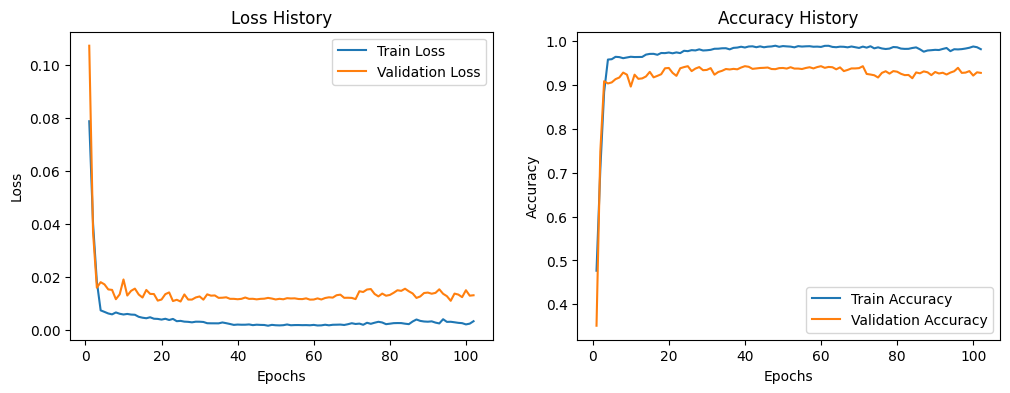

In [164]:
plot_history(history)